In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import accuracy_score
import re
import random
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [7]:
print('start reading...')
prefix = "/Users/isabelniu/Documents/HKUST-20Spring/ML/Project/DataSet/"
train = pd.read_csv(prefix + "train_data.csv")
test = pd.read_csv(prefix + "test_data.csv")
print('done reading')

start reading...
done reading


In [9]:
train=train.drop(train.columns[0],1)
train=train.drop(['expiration_date','registration_init_time'],1)
test=test.drop(test.columns[0],1)
test=test.drop(['expiration_date','registration_init_time'],1)

In [13]:
train.head(5)

,artist_name,bd,city,composer,expiration_date_day,expiration_date_month,expiration_date_year,gender,genre_ids,language,...,registered_via,registration_init_time_day,registration_init_time_month,registration_init_time_year,song_id,song_length,source_screen_name,source_system_tab,source_type,target
0,3784,0,0,16653,5,10,2017,2,307,9,...,2,2,1,2012,86884,20662,7,1,7,1.0
1,36867,24,11,74276,11,9,2017,0,97,9,...,3,25,5,2011,260594,39586,8,3,4,1.0
2,24601,24,11,51540,11,9,2017,0,97,9,...,3,25,5,2011,140755,25563,8,3,4,1.0
3,31651,24,11,41991,11,9,2017,0,6,1,...,3,25,5,2011,27577,33240,8,3,4,1.0
4,5190,0,0,9701,5,10,2017,2,2,9,...,2,2,1,2012,38706,16280,7,1,7,1.0


In [14]:
test.head(5)

,artist_name,bd,city,composer,expiration_date_day,expiration_date_month,expiration_date_year,gender,genre_ids,id,...,msno,registered_via,registration_init_time_day,registration_init_time_month,registration_init_time_year,song_id,song_length,source_screen_name,source_system_tab,source_type
0,42813,0,0,56689,18,9,2017,2,364,0.0,...,17724,2,19,2,2016,228222,25229,8,3,3
1,42633,0,0,79915,18,9,2017,2,371,1.0,...,17724,2,19,2,2016,407039,45559,8,3,3
2,38492,0,0,73206,24,11,2016,2,200,2.0,...,977,1,17,11,2016,70211,44899,22,0,10
3,36423,30,1,67327,30,4,2017,1,371,3.0,...,1878,3,25,7,2007,419092,39710,16,6,8
4,38298,30,1,52438,30,4,2017,1,519,4.0,...,1878,3,25,7,2007,160096,18478,16,6,8


(1475484, 11)

In [17]:
print('data split start...')
# Features and target varaibles
X = train.drop(columns='target',axis=1)
Y = train['target']
# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.2)

# Further split train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)
print('data split done.')

In [18]:
del X_train_all
del y_train_all
import gc
gc.collect()

199

In [19]:
# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [20]:
# Base line model
from sklearn.metrics import accuracy_score
m = LogisticRegression()
m.fit(X_train_sampled, y_train_sampled )
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.598


In [21]:
#determine the importance of features
def mod_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':np.abs(m.coef_[0])}
                       ).sort_values('imp', ascending=False)

fi = mod_feat_importance(m, X_train_sampled ); fi[:10]

,cols,imp
20,source_type,0.097940
7,gender,0.030532
9,language,0.017869
5,expiration_date_month,0.013591
12,registered_via,0.013451
19,source_system_tab,0.008115
14,registration_init_time_month,0.005281
18,source_screen_name,0.004919
6,expiration_date_year,0.001638
15,registration_init_time_year,0.001308


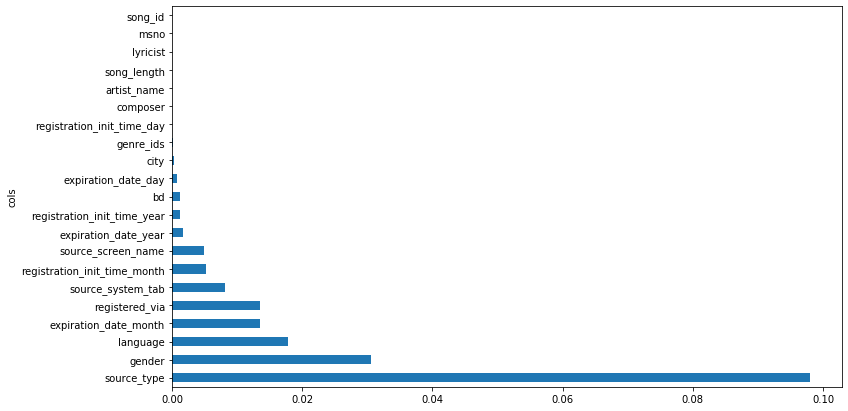

In [22]:
def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [23]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

11

In [24]:
X_train_sampled = X_train_sampled[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]
X_train = X_train[to_keep]

In [25]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', LogisticRegression())]) # Estimator: ML algorithm

grid_params = dict(clf__penalty=['l1', 'l2'],
                  clf__C = [.3,.5,.7,1])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.5989'

In [26]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Fitting best model
m = LogisticRegression(C=0.5,penalty='l2')
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.599


In [34]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.6


In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.60389621 0.59586699]
recall: [0.55795766 0.64040493]
fscore: [0.58001875 0.6173337 ]
support: [731258 744226]


Confusion matrix, without normalization
[[408011 323247]
 [267620 476606]]
Normalized confusion matrix
[[0.56 0.44]
 [0.36 0.64]]


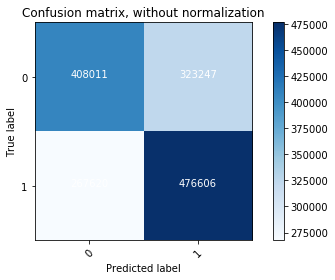

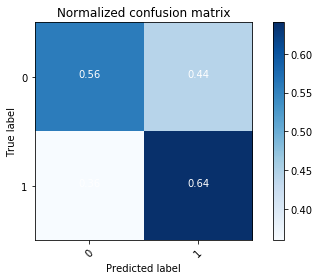

In [36]:
#plot confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [37]:
pd.DataFrame(predicted, columns=['LR']).to_csv('LR_test_score.csv',index=False)

In [38]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

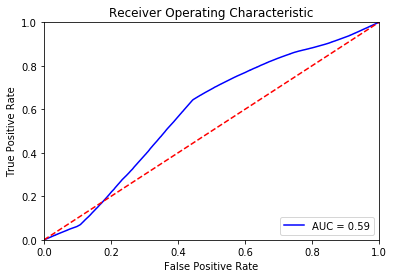

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()